# Groupe non officiel 1
# Livrable 2 - Traitement d'images

|Auteur|Centre|
|---|---|
|ACQUART Quentin|Aix-en-Provence|
|DIMEGLIO Nicolas|Aix-en-Provence|
|ROMANO Sébastien|Aix-en-Provence|
|SIXDENIER Alexandre|Aix-en-Provence|
|VESSERON Alexandre|Aix-en-Provence|

## Rappel du sujet
Le but est de traiter un ensemble de photographies afin de les rendre mieux traitables par les algorithmes de Machine Learning. Le traitement à réaliser est une opération de débruitage. Nous allons donc produire un notebook Jupyter explicitant ces étapes de prétraitement, et leurs performances. Ces algorithmes s'appuieront sur les auto-encodeurs à convolution, et les appliqueront pour améliorer la qualité de l'image.
<br>Toutes les parties doivent être détaillées dans le notebook :

    - Le code de chargement du fichier.

    - Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.

    - Une étude de cas.

## Analyse à effectuer

Le but de cette étape va être le suivant :
    Traiter l'ensemble des photographies via un bruitage puis un débruitage à fin d'améliorer leur qualité.
    Le tout à l'aide d'un auto-encodeur à convolution.


## Import des différentes bibliothèques

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import keras_tuner as kt
from keras import layers
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio
from keras.preprocessing import image
import datetime

## Téléchargement des données et dezippage
Pour cette partie se referrer au notebook [Préparation des données](Préparation_des_données.ipynb#section_1)
## Récupération des données
Une fois les datasets mis en place, sélectionner le dataset à utiliser dans la variable `dataset_path`


In [3]:
dataset_path = "../DatasetL2/Project_Dataset_Unzip/"

Pour commencer, nous devons spécifier quelques paramètres pour l'apprentissage:
<ul>
    <li>La longueur et la largeur des images. </li>
    <li>La taille du batch.</li>
</ul>

In [4]:
image_h = 320
image_w = 320
batch_s = 10


## Préparation des données

Nous devons partager le jeu de données en jeu d'entrainement et de validation à hauteur de 80/20.
Notre séparation du jeu de données va donc contenir 30 images en validation et 120 en entrainement



## Normalisation des données
Nous allons utiliser la fonction de création de jeu de données par répertoire.
<br>La fonction permet de transformer les images pour correspondre aux longueur et largeur définies.
<br>Les images pouvant être sous différent format nous normalisons les images en les transformant en image couleur rgb.

Nos dataset sont donc composées d'image en 320 par 320 et composées de 3 dimensions couleurs.

Nous avons choisi des batch de 10 pour correspondre au taille des jeux de validation et d'entrainement.

On doit d'abord bruité nos images. Pour cela nous utilisons une fonction de bruit gaussien pour rajouter du bruit sur chaque image.
Nous créeons 2 ImageDataGenerator afin de pouvoir créer un jeu de donneés bruité et normal.
Nous allons faire passer notre jeu de données dans ces générateurs pour transformer nos images présent dans notre dataset.
Pour ce faire nous allons rescale les images pour transformer les valeurs des pixels de (0,255) à (0,1).

In [5]:
def gaussian_noisy(img):
    img_resc = [pix*1./255 for pix in img]
    row,col,ch= img.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img_resc + gauss
    return noisy


normal_datagen = ImageDataGenerator(
        rescale=1./255,
        data_format="channels_last",
        validation_split=0.20
        )
noisy_datagen = ImageDataGenerator(
        preprocessing_function=gaussian_noisy,
        data_format="channels_last",
        validation_split=0.20
        )
train_generator = normal_datagen.flow_from_directory(
        dataset_path,
        subset = 'training',
        target_size=(image_h, image_w),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

train_noisy_generator = noisy_datagen.flow_from_directory(
        dataset_path,
        subset = 'training',
        target_size=(image_h, image_w),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

test_generator = normal_datagen.flow_from_directory(
        dataset_path,
        subset = 'validation',
        target_size=(image_h, image_w),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

test_noisy_generator = noisy_datagen.flow_from_directory(
        dataset_path,
        subset = 'validation',
        target_size=(image_h, image_w),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

Found 120 images belonging to 1 classes.
Found 120 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


## Mise en place des itérateurs

In [6]:
train_noisy= train_noisy_generator.next()
test_noisy= test_noisy_generator.next()
train = train_generator.next()
test = test_generator.next()
x_train = train
x_train_noisy = train_noisy
x_test = test
x_test_noisy = test_noisy


Nous allons préparer des fonctions d'affichage afin de vérifier l'état de nos images.
Le display_single_image nous permet d'afficher une image en désactivant les axes.
Le display_image nous permet d'afficher les n images que l'on souhaite.

In [43]:
def display_single_image(img):
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis("off")

def display_image(X, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[i].reshape(image_h, image_w,3))
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Grace aux fonctions d'affichages nous allons pouvoir visualiser les images bruitées.
Nous choissisons une image arbitrairement dans le dataset et y appliquons notre fonction de bruit gaussien.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


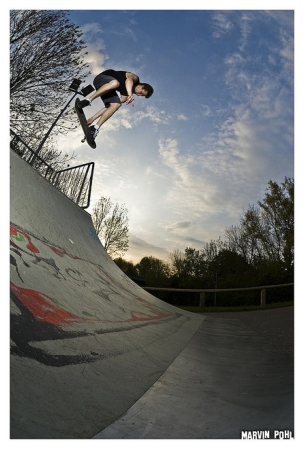

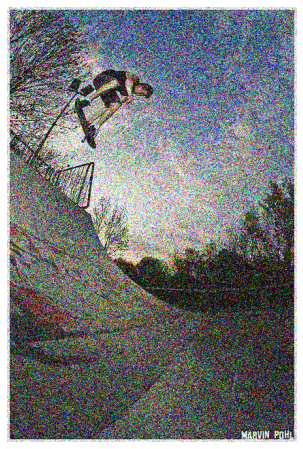

In [8]:
#Print 1 image for testing
img = image.load_img('../DatasetL2/Project_Dataset_Unzip/Dataset/noisy_139.jpg')  # this is a PIL image

img_decode = np.array(img)

display_single_image(img_decode)
display_single_image(gaussian_noisy(img_decode))

On peut remarquer que l'image est bruité, on peut noter aussi que le bruit est composées de pixels de différentes couleurs, correspondant à la colorisation de l'image (ici, RGB)
Nous allons donc visualiser un extrait de notre dataset pour observer l'effet du bruitage sur nos images.

Jeu de d'entrainement normale
Jeu de d'entrainement bruité
Jeu de de validation normale
Jeu de validation bruité


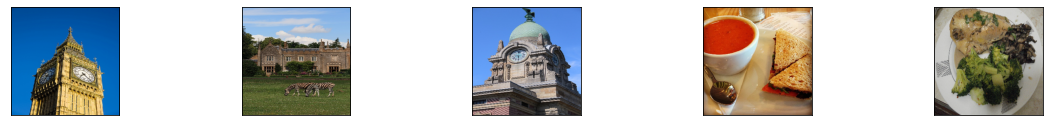

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

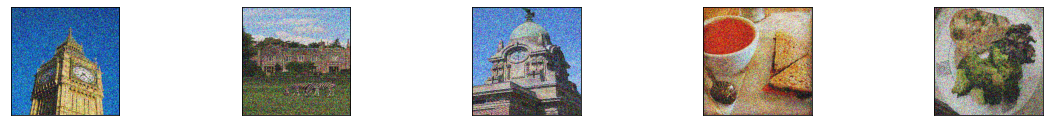

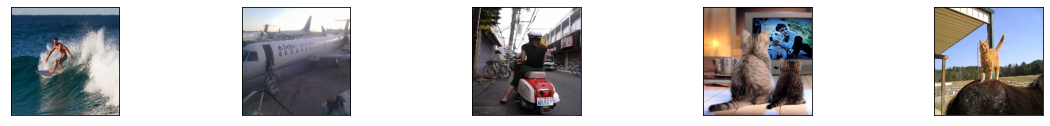

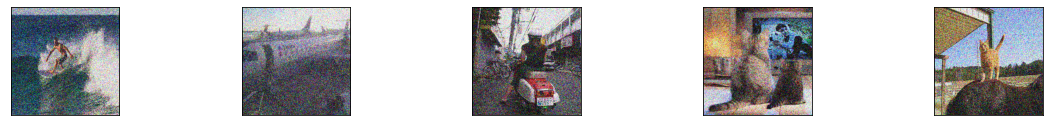

In [44]:
print("Jeu de d'entrainement normale")
display_image(x_train,5)
print("Jeu de d'entrainement bruité")
display_image(x_train_noisy,5)
print("Jeu de de validation normale")
display_image(x_test,5)
print("Jeu de validation bruité")
display_image(x_test_noisy,5)

#### Sauvegarde du model
Nous avons choisi d'implémenter une fonction de sauvegarde des meilleurs modèles s'executant à intervalle régulier.
Cela nous permet de récupérer les modèles les plus performants.

In [ ]:
name = 'L2_model.epoch{epoch:02d}-loss{val_loss:.4f}.hdf5'
checkpoint_filepath = '../model/' + name
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    #save_freq="epoch",
    save_best_only=True)

#### Modèle au complet :

Pour obtenir le meilleur modèle possible, nous allons entrainer le modèle sur 2000 epoch et enregister la version final
du model qui correspond au status du model à la dernière époch appelé : `final_train_model.h5`

In [47]:
def custom_loss(y_true, y_pred):
    (score, diff) = structural_similarity(y_true, y_pred, multichannel=True, full=True)
    return score

In [49]:
number_epochs = 2000
input_img = keras.Input(shape=(image_h, image_w, 3))

encoded = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)


decoded = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded) #decoded
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
decoded = keras.layers.UpSampling2D((2, 2))(decoded)
decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

auto_encoder = keras.Model(input_img, decoded)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
auto_encoder.compile(optimizer = optimizer,
                  loss = 'mean_squared_error')
auto_encoder.summary()
history = auto_encoder.fit(x_train_noisy, x_train,
                epochs=number_epochs,
                batch_size=batch_s,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                #callbacks=[model_checkpoint_callback]
                )
auto_encoder.save('../model/final_train_model'+ datetime.datetime.now() +'.h5')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 320, 320, 128)     3584      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 160, 160, 128)     0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 160, 160, 64)      73792     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 80, 80, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 80, 80, 32)        18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 40, 40, 32)        0   

KeyboardInterrupt: 

## Courbe Loss

Notre fonction Loss est `mean_squared_error`. C'est donc une fonction Loss de régression ce qui n'est pas idéale pour
mesurer le niveau de bruit dans l'image. Pour se rendre compte de cela, nous allons afficher la courbe Loss pour obtenir
un visuel d'entrainement de notre modèle.

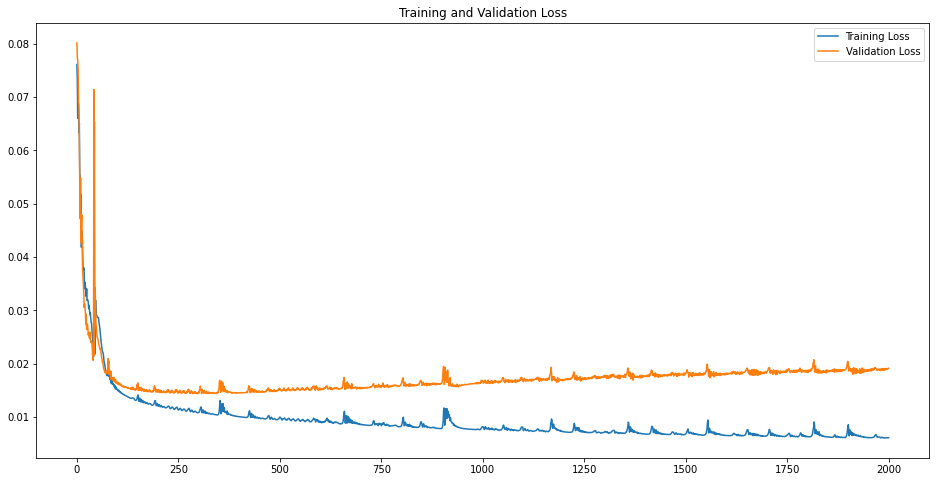

<Figure size 432x288 with 0 Axes>

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(number_epochs)
plt.figure(figsize=(16, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
plt.savefig("images/Courbe_loss_L2.png")

Ici on peut donc observer, qu'à partir de 200 epochs, la validation Loss diminue progressivement par rapport à la traning Loss.
C'est un signe d'overfit, cependant dans le cas d'un débruitage d'une image par un auto-encodeur, le sur-entrainement
sur le jeu de données n'est pas forcément signe de dégradation de l'image.

## Affichage des différentes couches de notre modèle

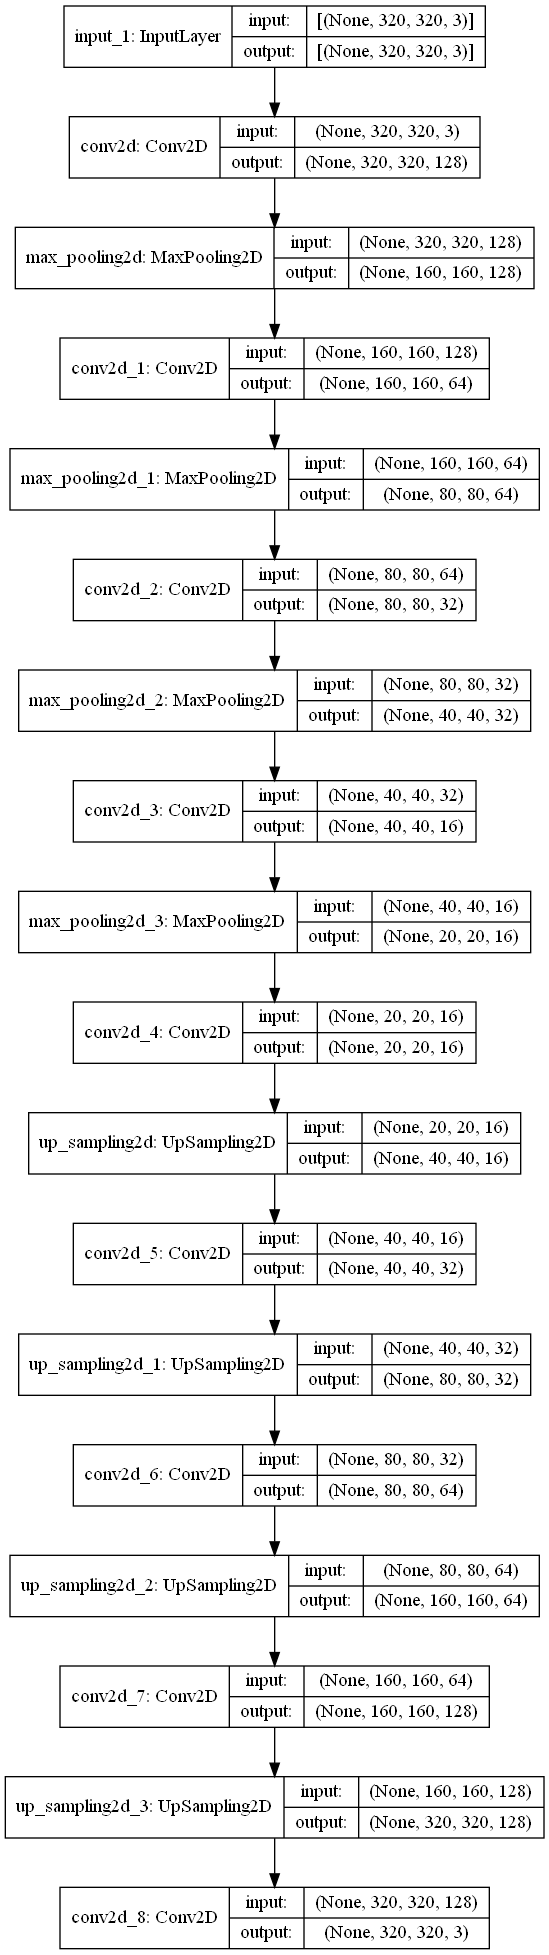

In [12]:
tf.keras.utils.plot_model(auto_encoder, show_shapes=True)

## Prédiction de notre modèle
Afin de vérifier le bon fonctionnement de notre modèle, nous allons le tester sur notre jeu de test.

In [13]:
decoded_imgs = auto_encoder.predict(x_test_noisy, verbose=1)
print(decoded_imgs.shape)

1/1 [==============================] - 0s 126ms/step
(10, 320, 320, 3)


On compare notre image bruitée et son débruitage dans l'auto-encodeur.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

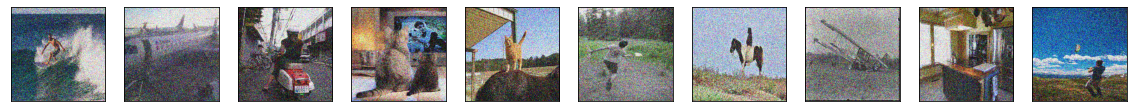

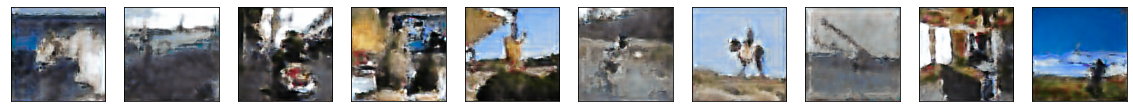

In [14]:
display_image(x_test_noisy,10)
display_image(decoded_imgs,10)

On remarque que les images on perdu beaucoup de bruit gaussien, néanmoins certaines images peuvent rester flou et d'autres
peuvent perdre les couleurs d'origine (la teinte des couleurs varie légèrement).

Nous avons sauvegarder l'époch avec la loss la plus basse et nous aller comparer l'image de sortie à notre image bruitée.

In [15]:
low_epoch_model = tf.keras.models.load_model('../model/L2_model.epoch294-loss0.0147.hdf5')
low_epoch_decoded_img = low_epoch_model.predict(x_test_noisy, verbose=1)

1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

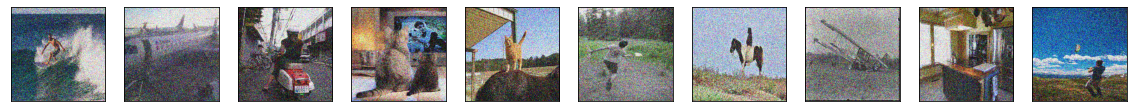

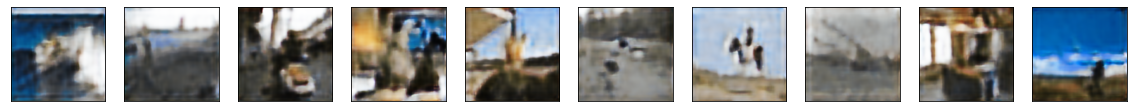

In [16]:
display_image(x_test_noisy,10)
display_image(low_epoch_decoded_img,10)

On remarque que l'image est beaucoup plus flou que notre modèle à 2000 epochs. Les images perdent beaucoup de détails
et de couleur rendant certaines images illisibles. On peut en conclure que notre fonction Loss `mean_squared_error`
ne permet pas de derterminer le meilleur modèle pour le débrouitage d'image par un auto-encodeur.

Nous cherchons donc une autre métrique pour déterminer la qualitée de l'image afin de comparer les résultats de nos
différents modèles.

## SSIM, MSE & PKSNR
- Le `SSIM` est une méthode utilisée pour prédire la qualitée perçu des images. Cette métrique permet de mesurer la
similarité entre deux images.
Le `SSIM` prend un compte le masquage, la luminance et le constrate. La différence avec d'autres techniques tel que le
`MSE`, elle estime les erreurs absolues.
- Le `MSE` premet de calculer la somme des carrées des différences pour chaque pixel de l'image. Ce qui nous rends un
score représentatif de l'erreur entre les images.
- Le `PKSNR`est le rapport entre la puissance possible maximal d'un signal et la puissance du bruit corrupteur qui
affecte la fidélité de sa représentation. Il s'exprime sous la forme du quantité logarithmique utilisant
l'échelle des décibels (db). Il est couramment utilisé pour quantifier la qualité de reconstruction des images soumises
à une compression avec perte.

In [29]:
def ssim_score_compare(first_batch_pictures,second_batch_pictures):
    ssim_list_score = []
    for img_first_batch,img_second_batch in zip(first_batch_pictures,second_batch_pictures):
        (score, diff) = structural_similarity(img_first_batch, img_second_batch, multichannel=True, full=True)
        #diff = (diff * 255).astype("uint8")
        ssim_list_score.append(score)
    return ssim_list_score

def mse_score_compare(first_batch_pictures,second_batch_pictures):
    mse_list_score = []
    for img_first_batch,img_second_batch in zip(first_batch_pictures,second_batch_pictures):
        score = mean_squared_error(img_first_batch, img_second_batch)
        mse_list_score.append(score)
    return mse_list_score

def pksnr_score_compare(first_batch_pictures,second_batch_pictures):
    pksnr_list_score = []
    for img_first_batch,img_second_batch in zip(first_batch_pictures,second_batch_pictures):
        score = peak_signal_noise_ratio(img_first_batch, img_second_batch,data_range=1)
        pksnr_list_score.append(score)
    return pksnr_list_score

Comparaison des scores `SSIM, MSE & PKSNR` entre l'image normale et l'image bruitée.

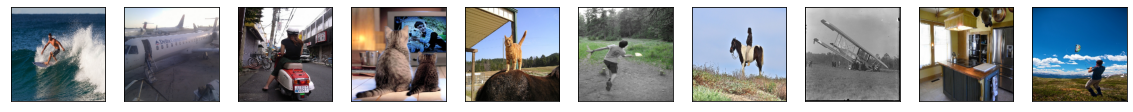

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

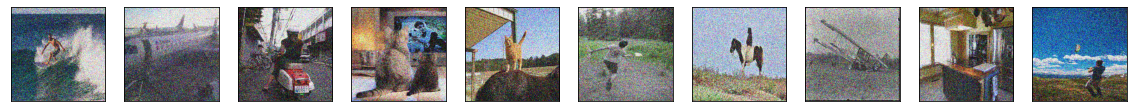

SSIM[0.15072797756249703, 0.07090576569072889, 0.21311130345733, 0.1343327088353739, 0.1689343364360292, 0.12401504577108997, 0.1711619174412827, 0.11081432956484742, 0.1469259833024097, 0.1209069997860795]
MSE[0.10024109837429286, 0.10016658185941335, 0.1003845415592089, 0.1003217292348975, 0.10002952399597959, 0.10018615799674421, 0.1003219908853371, 0.10009697870799142, 0.10007406552268353, 0.09962959786545152]
PKSNR[9.989541832820526, 9.99277146081447, 9.983331600238932, 9.986049905613907, 9.998717978388926, 9.991922776793187, 9.986038578736393, 9.995790309147852, 9.99678456583705, 10.016116226194997]


In [45]:
display_image(x_test,10)
display_image(x_test_noisy,10)
print("SSIM" + str(ssim_score_compare(x_test,x_test_noisy)))
print("MSE" + str(mse_score_compare(x_test,x_test_noisy)))
print("PKSNR" + str(pksnr_score_compare(x_test,x_test_noisy)))

`SSIM, MSE & PKSNR` en utilisant notre modèle avec 2000 epochs.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

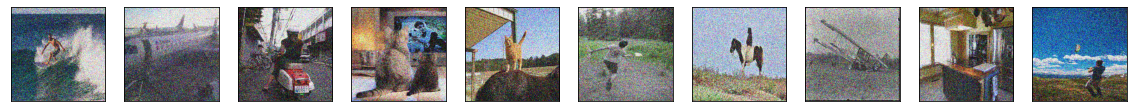

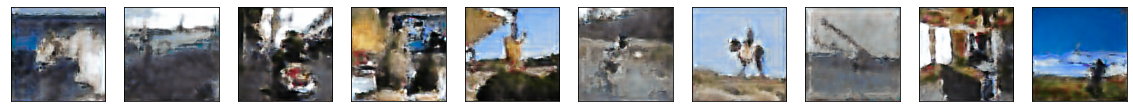

SSIM[0.03806758085287449, 0.04070414250601919, 0.04606453386065904, 0.05152147492348993, 0.047787059344011514, 0.04043386344412841, 0.041042920473177646, 0.03845048772899436, 0.04901070894843388, 0.034112232079263956]
MSE[0.11918939130887767, 0.10788452107837054, 0.1307561057140673, 0.12385354242414472, 0.12150412716952341, 0.11159161129684736, 0.1209399985802041, 0.11515025264839823, 0.12311898657068837, 0.11654431821312695]
PKSNR[9.237623981280759, 9.670408620129304, 8.835380224146775, 9.070915673320226, 9.15408969995645, 9.523684514953974, 9.174300408285518, 9.387351048236333, 9.09674967970025, 9.33508894419981]


In [30]:
display_image(x_test_noisy,10)
display_image(decoded_imgs,10)
print("SSIM" + str(ssim_score_compare(x_test_noisy,decoded_imgs)))
print("MSE" + str(mse_score_compare(x_test_noisy,decoded_imgs)))
print("PKSNR" + str(pksnr_score_compare(x_test_noisy,decoded_imgs)))

`SSIM, MSE & PKSNR` en utilisant notre modèle sauvegarder avec la meilleure MSE Loss.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

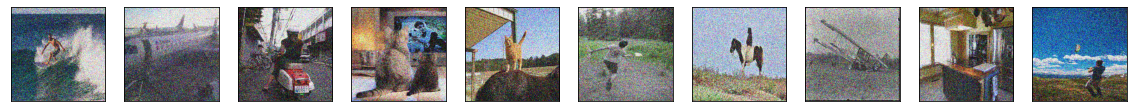

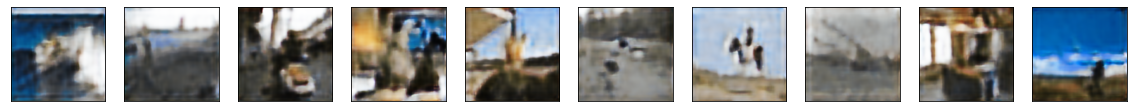

SSIM[0.04325979957786308, 0.04029708865032856, 0.04574835267609659, 0.05109547911642687, 0.04552660758115856, 0.04010747808414412, 0.04173252171048721, 0.03735160916350735, 0.05105543856946646, 0.03688759283026959]
MSE[0.11359491464282631, 0.10459640525474811, 0.12398214570864527, 0.11543474513566555, 0.11845279308367206, 0.10904665288562111, 0.1174048844476029, 0.11561345171675227, 0.11497398623856081, 0.11270043914528406]
PKSNR[9.446411104559306, 9.804832409453558, 9.066408517611784, 9.37663451583026, 9.264546942782797, 9.62387660260558, 9.303138345661385, 9.369916324684013, 9.394004110467275, 9.48074391691231]


In [31]:
display_image(x_test_noisy,10)
display_image(low_epoch_decoded_img,10)
print("SSIM" + str(ssim_score_compare(x_test_noisy,low_epoch_decoded_img)))
print("MSE" + str(mse_score_compare(x_test_noisy,low_epoch_decoded_img)))
print("PKSNR" + str(pksnr_score_compare(x_test_noisy,low_epoch_decoded_img)))

## Conclusion

<br>On voit sur notre graphe que notre modèle Overfit légèrement sur nos données d'entrainement, on remarque que la courbe du loss et de l'accuracy sur nos données de validations ne progressent plus au dela d'un certain seuil contrairement à nos données d'entrainement.
<br>Pour améliorer nos résultats nous pouvons appliquer une méthode de transfer learning pour avoir un réseau plus gros et une extraction plus fine des features ce qui nous donne une meilleur précision. Nous pouvons également construire plusieurs modèles spécialisé puis les concaténer dans le but de créer un modèle plus robuste qui devrait avoir de meilleur résultat tout en limitant les risques d'overfit/underfit. Egalement une cross validation peut être mis en place pour

## Recherche d'un meilleur modèle

Pour la recherche d'un meilleur modèle, nous allons intégrer un tuner nous permettant d'affiner les hyperparamètres
afin d'obtenir de meilleur résultat. Par la même occasion, nous allons introduire la crossvalidation à notre modèle.

Pour ce faire nous allons nous baser sur les paramètres de notre meilleur modèle actuel à 2000 epoch avec un optimizer
adam et un learning rate de 0.002.

Nous allons utiliser le module `keras.tuner` disponible dans la librairie keras.

### Tuner Modèle avec les meilleurs paramètres

In [ ]:
def build_model(hp):
  model_type = hp.Choice('model_type', ['deep_learning'])
  if model_type == 'deep_learning':

    input_img = keras.Input(shape=(image_h, image_w, 3))

    encoded = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
    encoded = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)
    #encoded = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    #encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(encoded)

    #decoded = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    #decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded) #decoded
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(decoded)
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(decoded)
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(decoded)
    decoded = keras.layers.UpSampling2D((2, 2))(decoded)
    decoded = keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)

    auto_encoder = keras.Model(input_img, decoded)

    choice_optimizer = hp.Choice('optimizer', ['Adam','SGD'])
    if choice_optimizer == 'Adam':
        auto_encoder.compile(optimizer = tf.keras.optimizers.Adam(
        learning_rate= hp.Float('learning_rate', 0.001, 0.004, sampling='log')),
        loss = 'mean_squared_error')
    elif choice_optimizer == 'SGD':
        auto_encoder.compile(optimizer = tf.keras.optimizers.SGD(
        learning_rate= hp.Float('learning_rate', 0.001, 0.004, sampling='log')),
        loss = 'mean_squared_error')

    model = auto_encoder
  return model

In [ ]:
print(x_train.shape)

In [ ]:
normal_datagen_tuner = ImageDataGenerator(
        rescale=1./255,
        #preprocessing_function=noisy,
        data_format="channels_last",
        )
noisy_datagen_tuner = ImageDataGenerator(
        #rescale=1./255,
        preprocessing_function=gaussian_noisy,
        data_format="channels_last",
        )

train_generator_tuner = noisy_datagen_tuner.flow_from_directory(
        dataset_path,
        target_size=(image_h, image_w),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

test_generator_tuner = normal_datagen_tuner.flow_from_directory(
        dataset_path,
        target_size=(image_h, image_w),
        batch_size=batch_s,
        shuffle=False,
        class_mode=None,
        )

train_tuner = train_generator_tuner.next()
test_tuner = test_generator_tuner.next()
x_train_tuner = train_tuner
y_test_tuner = test_tuner

In [ ]:
name = 'L2_Tuner_model.epoch{epoch:02d}-loss{val_loss:.4f}.hdf5'
checkpoint_filepath = '../model/' + name
model_checkpoint_callback_tuner = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    #save_freq="epoch",
    save_best_only=True)

In [ ]:
import numpy as np
from sklearn import model_selection
epochs_tuner = 100
class CVTuner(kt.engine.tuner.Tuner):
  def run_trial(self, trial, x, y, batch_size=batch_s, epochs=epochs_tuner):
    cv = model_selection.KFold(5)
    val_losses = []
    for train_indices, test_indices in cv.split(x):
      x_train, x_test = x[train_indices], x[test_indices]
      y_train, y_test = y[train_indices], y[test_indices]
      model = self.hypermodel.build(trial.hyperparameters)
      model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,shuffle=True,
                validation_data=(x_test, y_test),
                #callbacks=[model_checkpoint_callback_tuner]
                )
      val_losses.append(model.evaluate(x_test, y_test))
    self.oracle.update_trial(trial.trial_id, {'val_loss': np.mean(val_losses)})
    self.save_model(trial.trial_id, model,epochs_tuner)
tuner = CVTuner(
  hypermodel=build_model,
  directory='keras_tuner_dir',
  project_name='keras_tuner_demo',
  oracle=kt.oracles.BayesianOptimization(
    objective='val_loss',
    max_trials=2))
tuner.search(x_train_tuner, y_test_tuner, batch_size=batch_s, epochs=epochs_tuner)

In [ ]:
full_epoch_model = tf.keras.models.load_model('../model/final_train_model.h5')
full_decoded_img = full_epoch_model.predict(x_train_noisy, verbose=1)

In [ ]:
print(ssim_score_compare(x_train,low_epoch_decoded_img))
display_image(low_epoch_decoded_img,10)

In [ ]:
print(ssim_score_compare(x_train,full_decoded_img))